In [1]:
%pylab inline
import geopandas as gpd
import rasterio as rio
import rasterio.plot as rplot
import itertools

Populating the interactive namespace from numpy and matplotlib


In [2]:
mounds_f = "MARS-Dataset/training_site/mapping/polygons/mounds.shp"
dem_f = "MARS-Dataset/training_site/DEM/Low-res_DEM/Firsoff_HiRISE_5_low_res.tif-adj.tif"
vents_f = "MARS-Dataset/training_site/mapping/points/vent_points.shp"

In [3]:
data = gpd.read_file(mounds_f)

toremove = []
for id, gg in enumerate(data.geometry):
    if not gg.is_valid:
        print(f"not valid {id}")
        toremove.append(id)

data = data.drop(toremove)
data.drop_duplicates(inplace=True)

vents = gpd.read_file(vents_f)



not valid 56
not valid 92
not valid 100
not valid 163
not valid 200
not valid 329
not valid 330


In [4]:
#Simple Mounds
simple_mounds = data[data.Morpho == "simple"]

PROJCS["Mars_Sinusoidal",GEOGCS["GCS_Mars_Sphere",DATUM["D_Mars_Sphere",SPHEROID["Mars_Sphere",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",350],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


<AxesSubplot:>

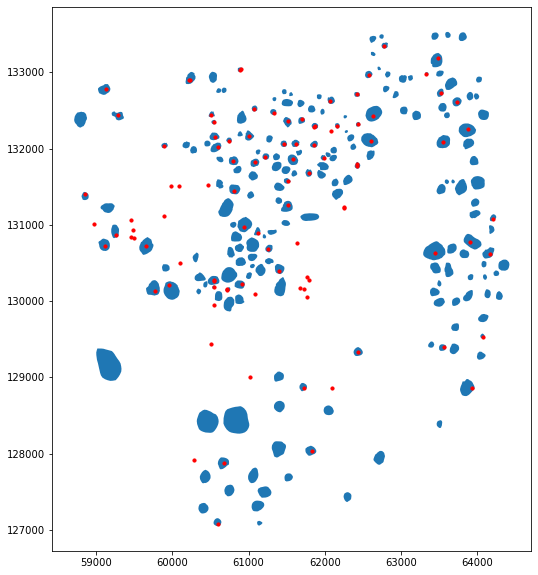

In [5]:
print(simple_mounds.crs)
figure(figsize = (10,10))
simple_mounds.plot(ax=gca())
vents.plot(ax=gca(), color = "red", markersize=10)

In [6]:
dem_source = rio.open(dem_f)
dtm = dem_source.read()
meta = dem_source.meta

In [7]:
dtm

array([[[-32767., -32767., -32767., ..., -32767., -32767., -32767.],
        [-32767., -32767., -32767., ..., -32767., -32767., -32767.],
        [-32767., -32767., -32767., ..., -32767., -32767., -32767.],
        ...,
        [-32767., -32767., -32767., ..., -32767., -32767., -32767.],
        [-32767., -32767., -32767., ..., -32767., -32767., -32767.],
        [-32767., -32767., -32767., ..., -32767., -32767., -32767.]]],
      dtype=float32)

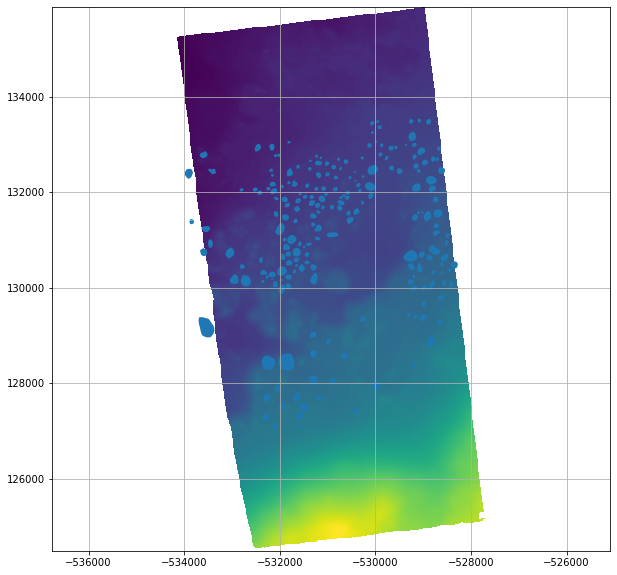

In [8]:
figure(figsize=(10,10))
axis("equal")
rplot.show(dem_source, ax=gca())
data_ = simple_mounds.to_crs(meta["crs"])
data_.plot(ax=gca(), column = "Morpho")

grid()

In [9]:
# dem_source.nodatavals

In [10]:
# mask = dem_source.read_masks(1)

In [11]:
# mask

In [20]:
import rasterio.mask as mask

In [12]:
import shutil

tmp = shutil.copy(dem_f, "tmp.tif")
src = rio.open(tmp, mode="r+")
src.write_mask(True)
src.read_masks(1).all()
src.close()

In [13]:
src = rio.open("tmp.tif")


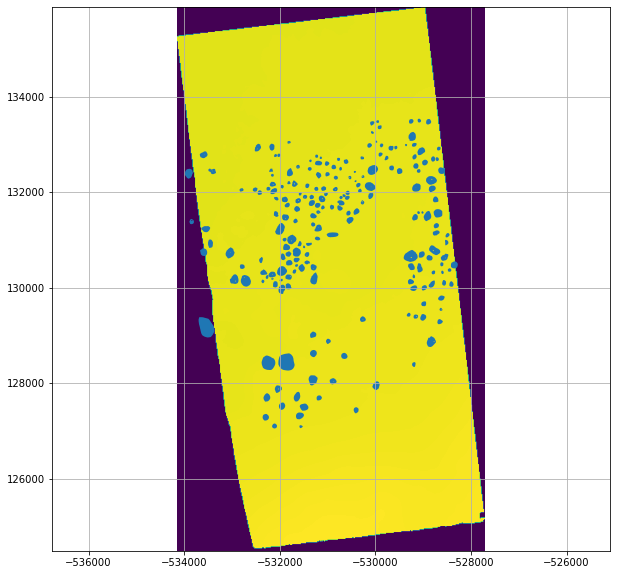

In [14]:
figure(figsize=(10,10))
# imshow(src, interpolation=None)
axis("equal")
rplot.show(src, ax=gca())
data_ = simple_mounds.to_crs(meta["crs"])
data_.plot(ax=gca(), column = "Morpho")

grid()

In [15]:
src.transform

Affine(18.0, 0.0, -534141.0,
       0.0, -18.0, 135873.0)

C:\Users\salee\AppData\Local\Temp/ipykernel_9764/3332600213.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure()


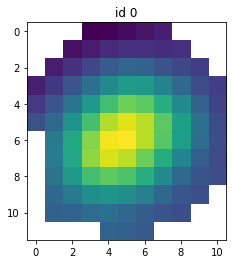

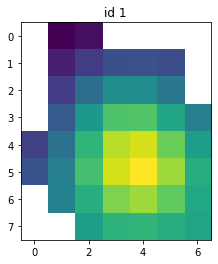

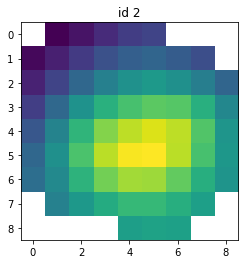

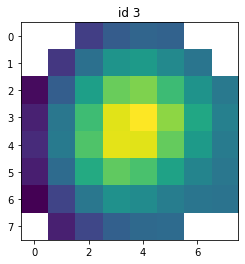

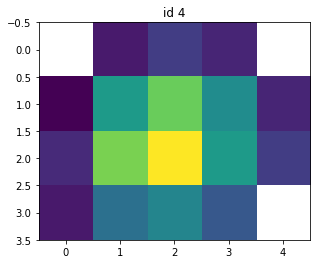

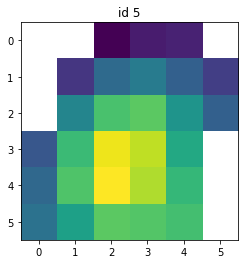

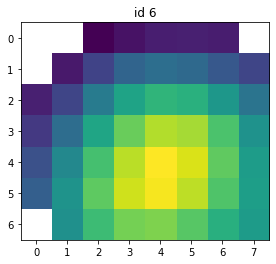

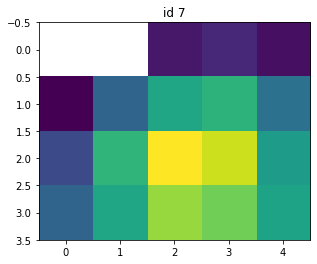

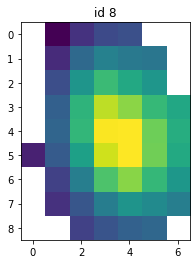

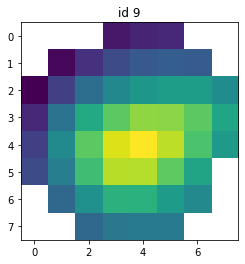

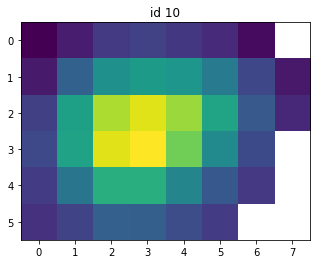

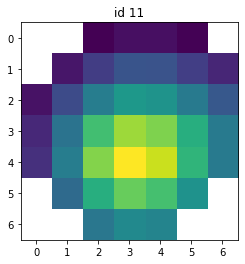

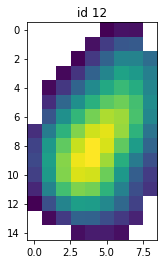

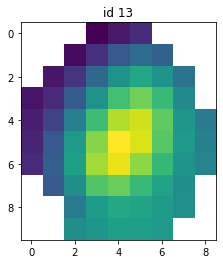

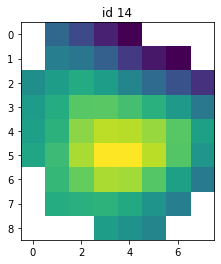

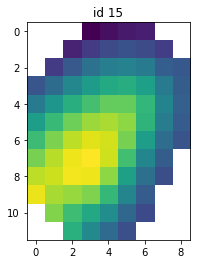

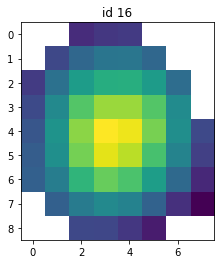

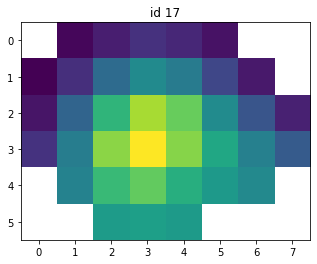

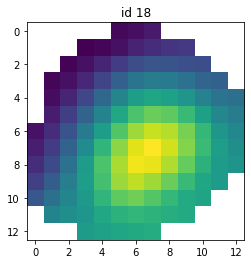

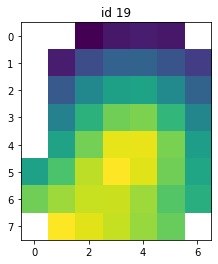

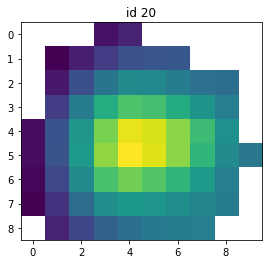

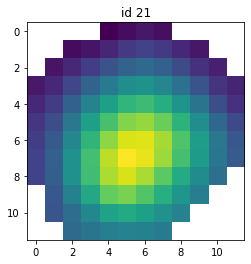

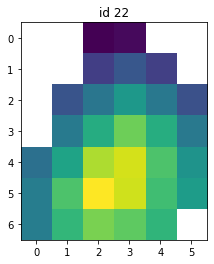

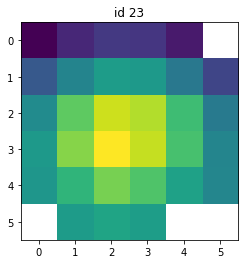

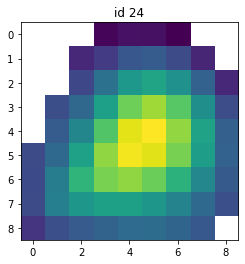

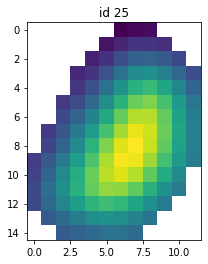

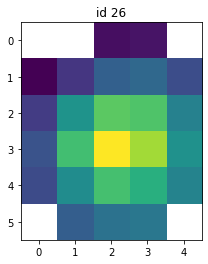

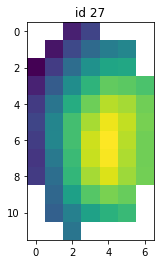

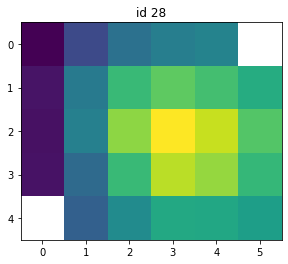

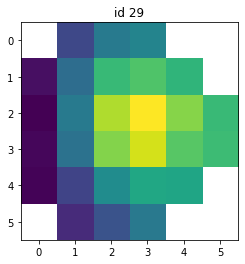

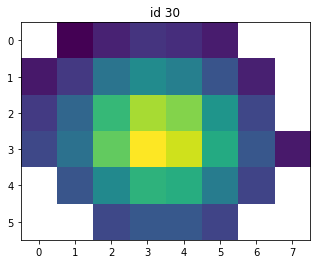

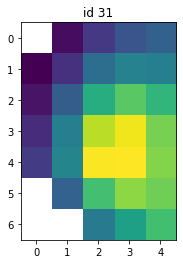

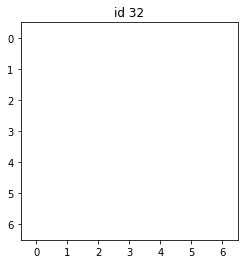

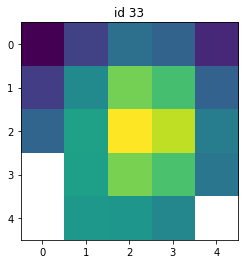

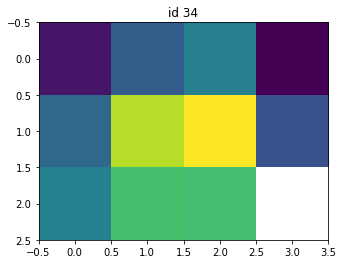

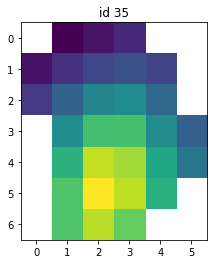

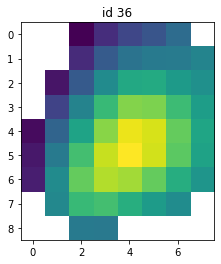

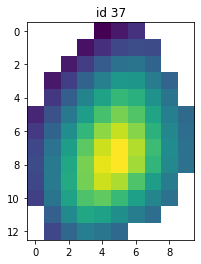

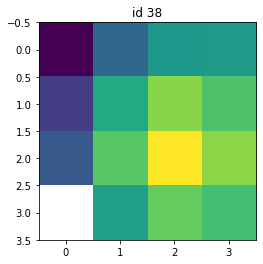

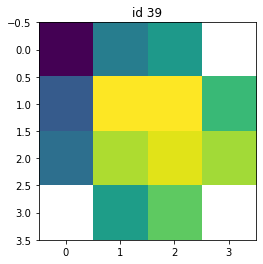

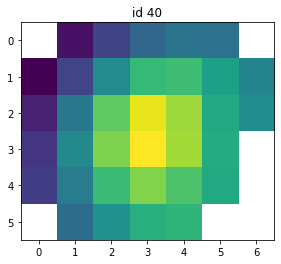

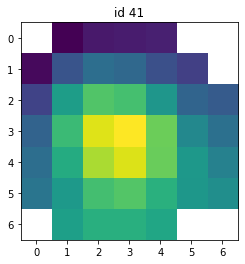

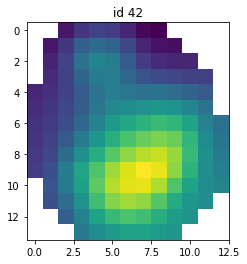

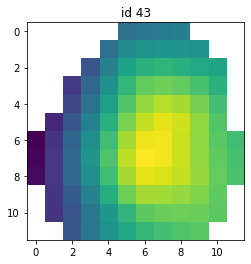

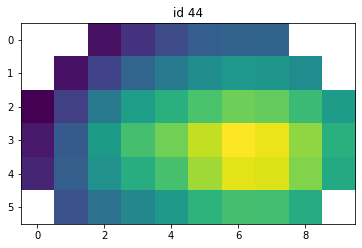

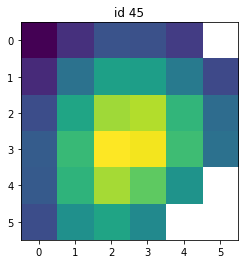

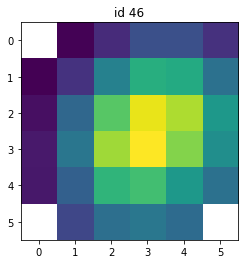

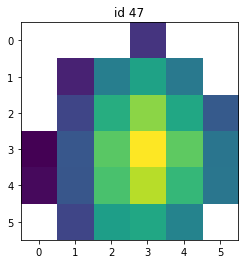

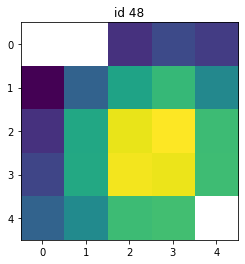

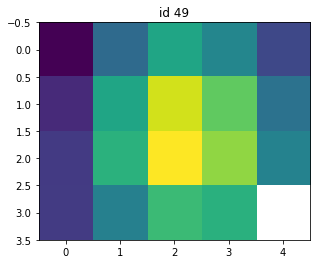

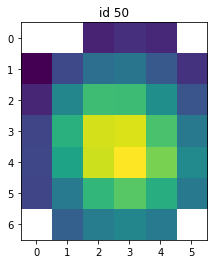

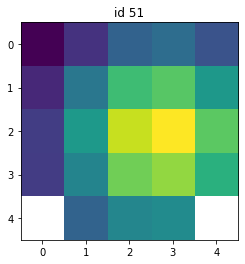

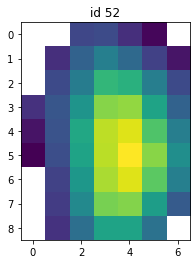

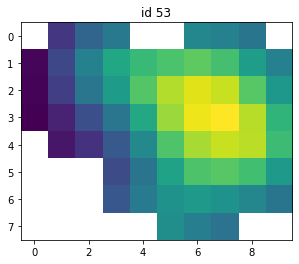

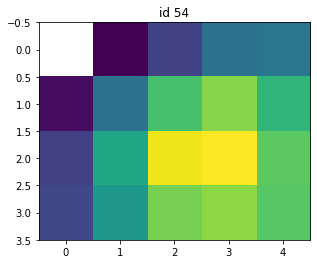

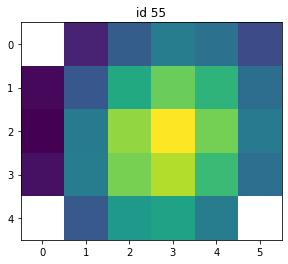

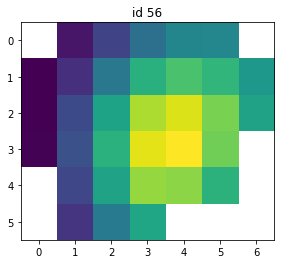

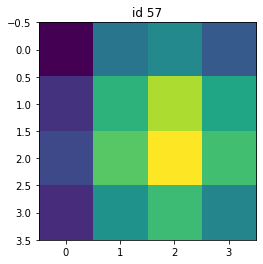

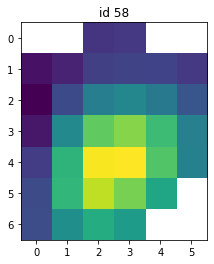

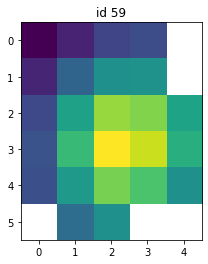

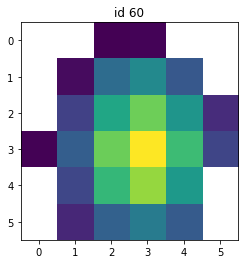

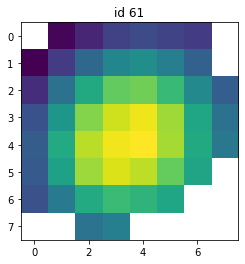

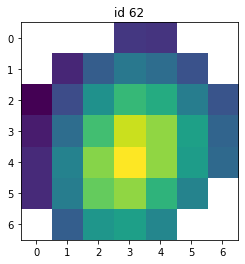

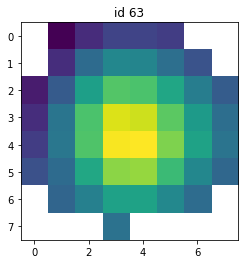

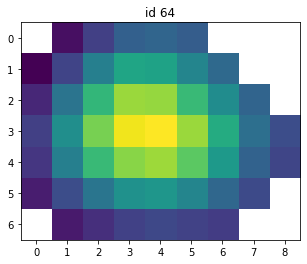

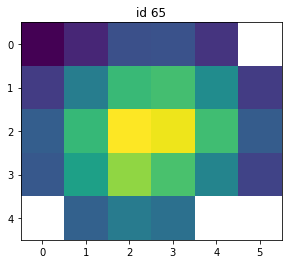

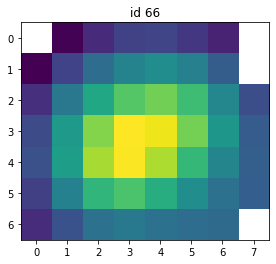

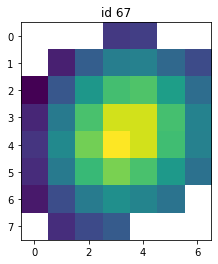

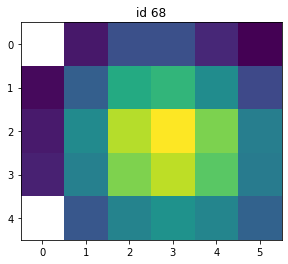

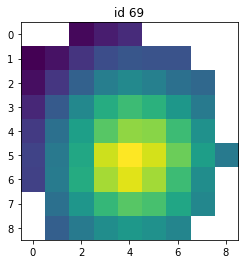

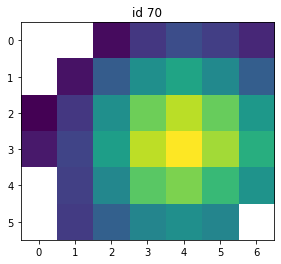

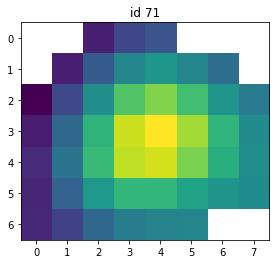

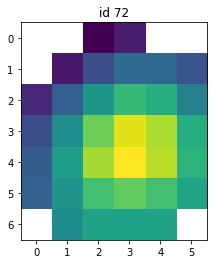

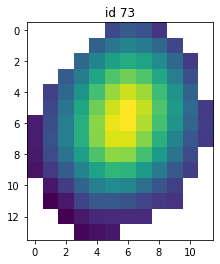

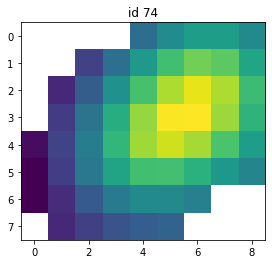

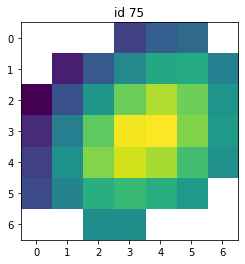

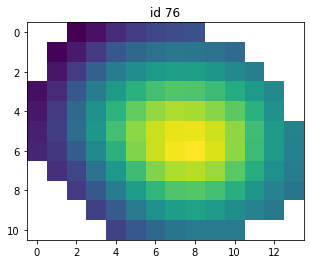

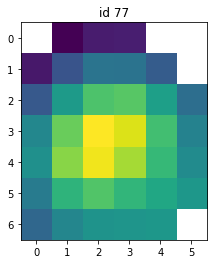

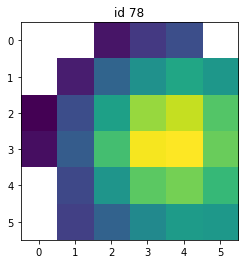

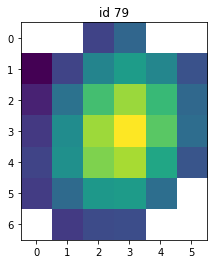

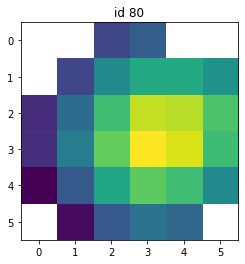

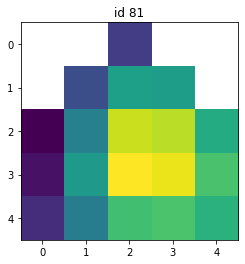

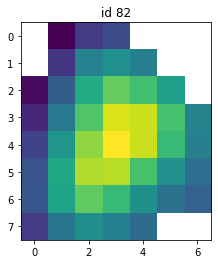

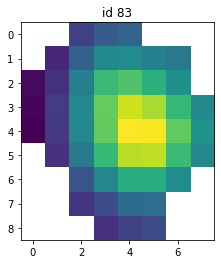

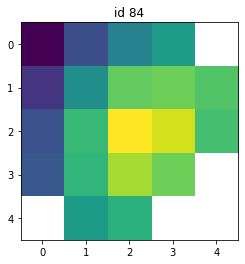

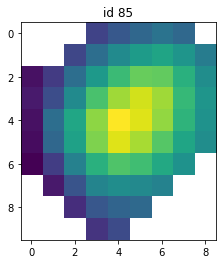

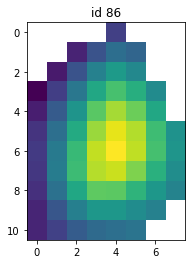

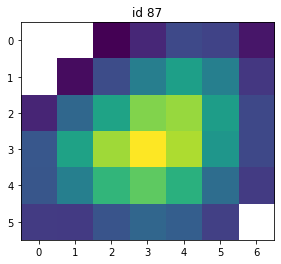

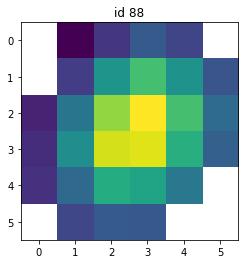

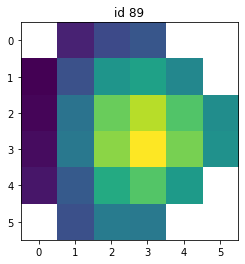

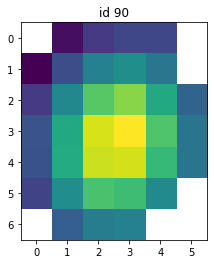

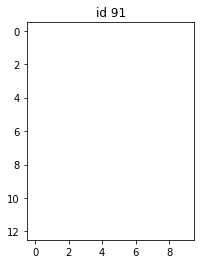

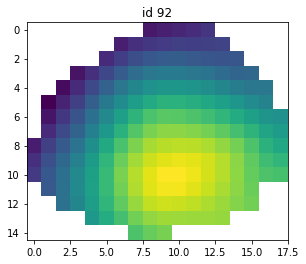

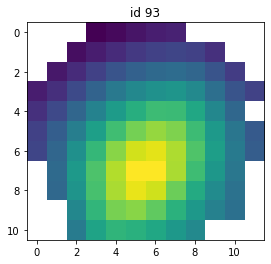

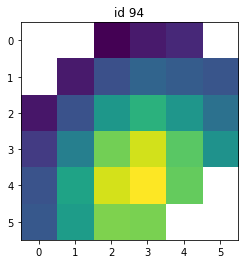

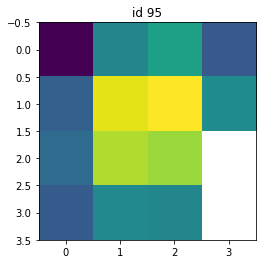

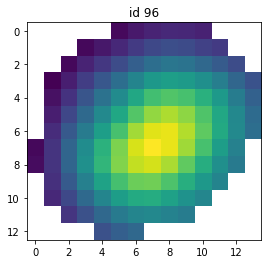

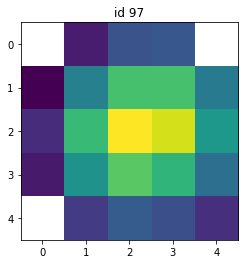

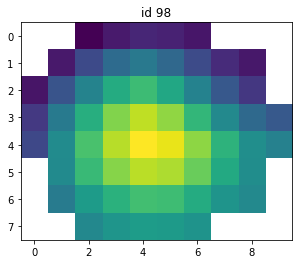

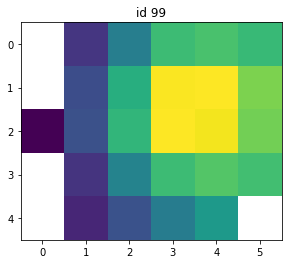

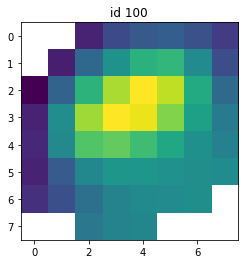

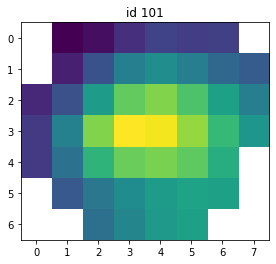

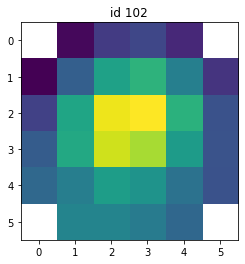

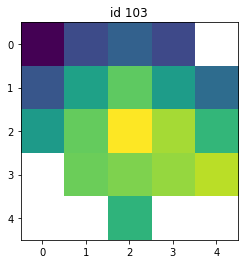

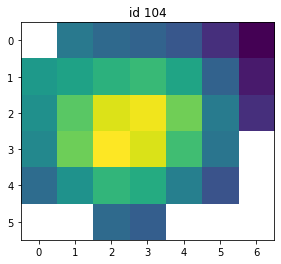

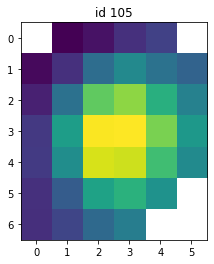

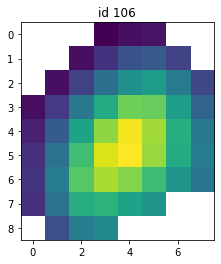

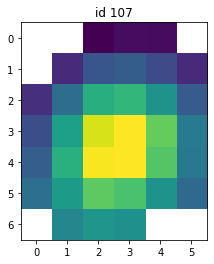

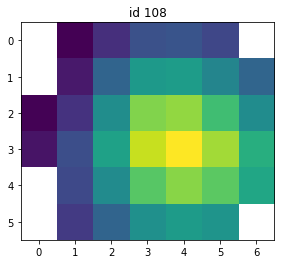

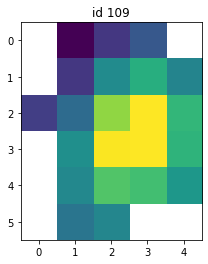

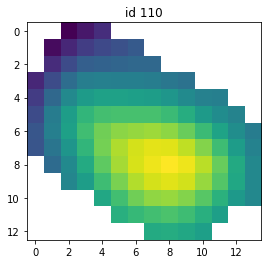

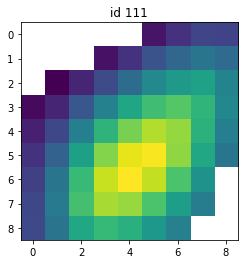

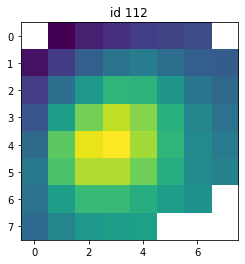

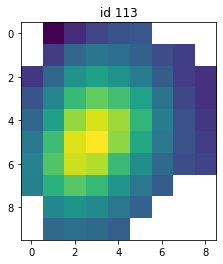

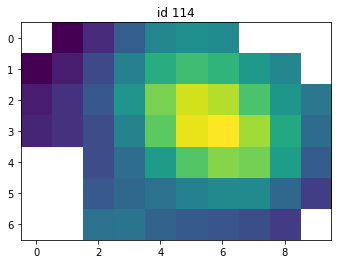

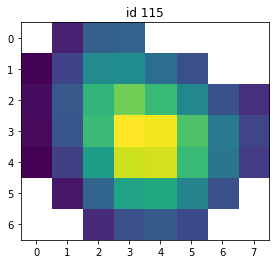

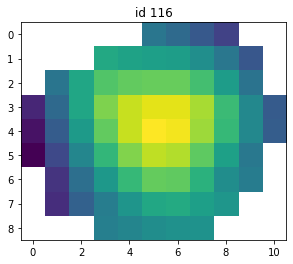

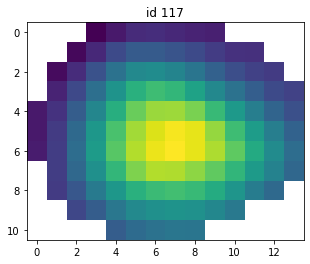

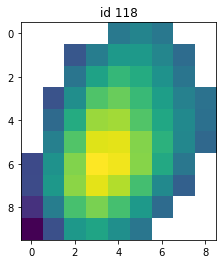

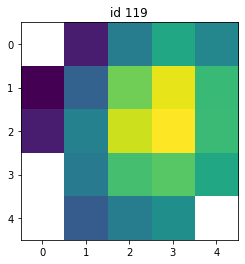

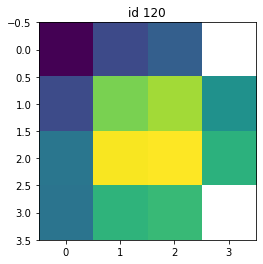

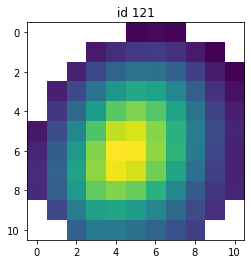

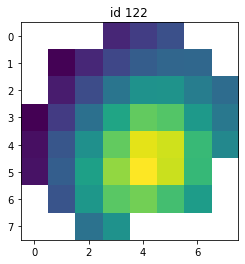

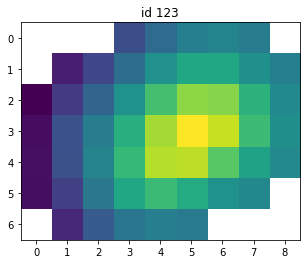

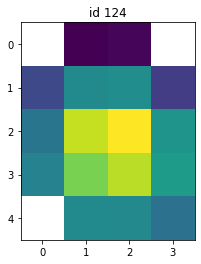

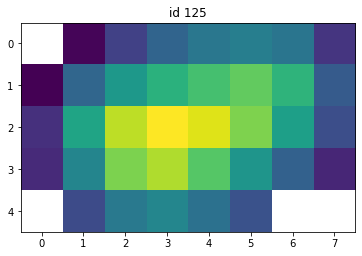

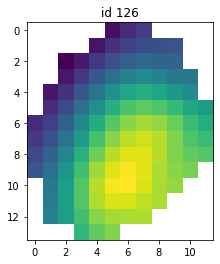

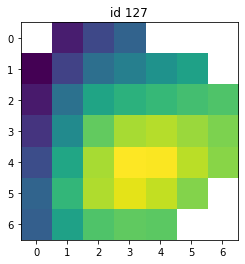

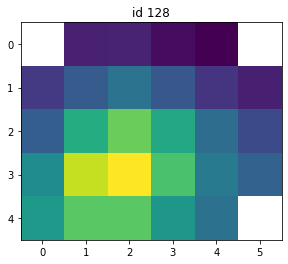

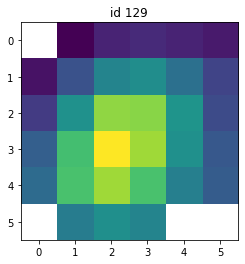

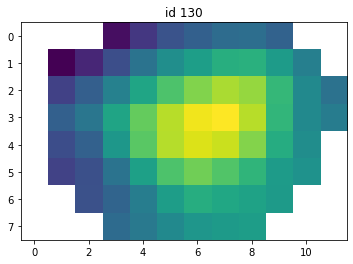

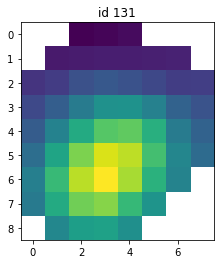

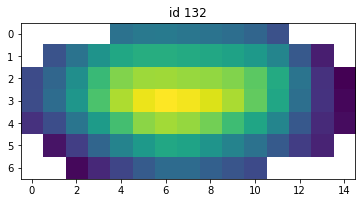

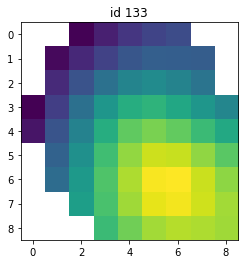

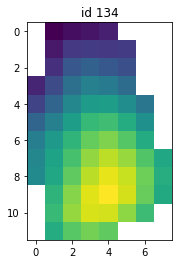

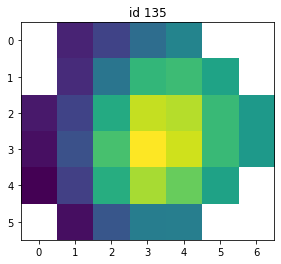

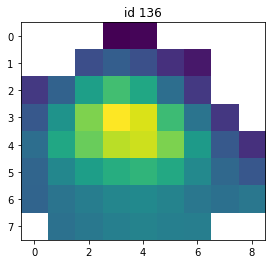

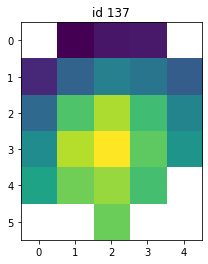

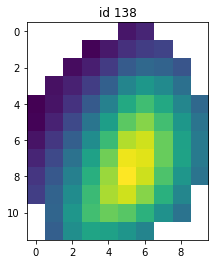

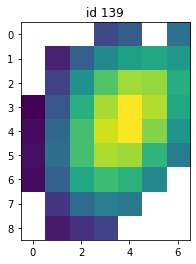

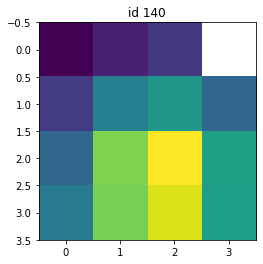

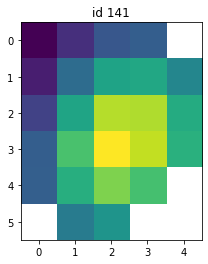

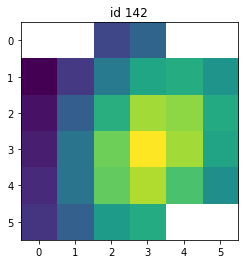

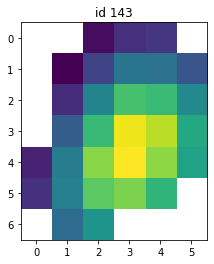

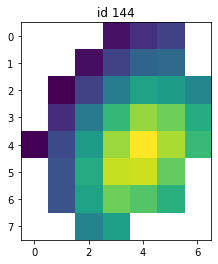

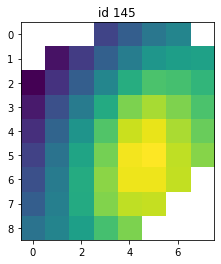

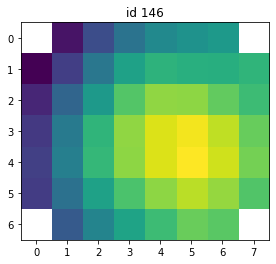

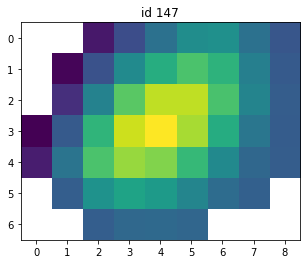

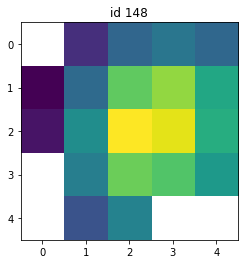

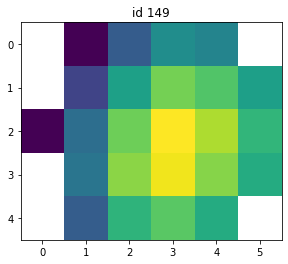

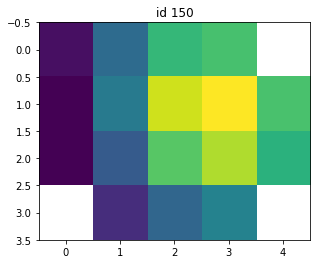

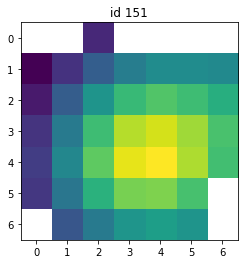

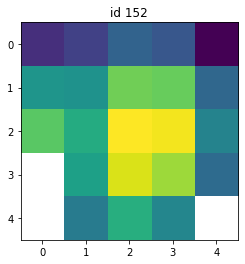

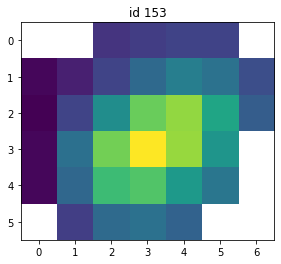

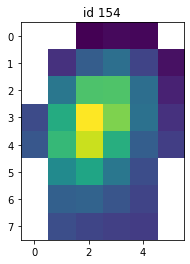

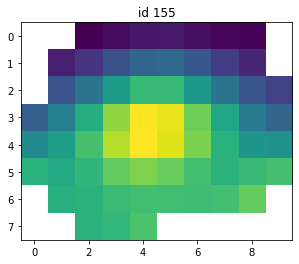

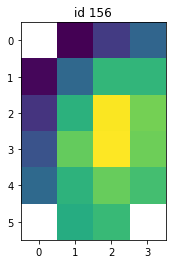

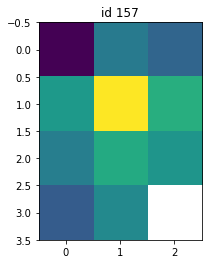

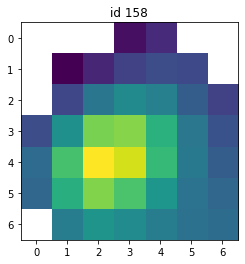

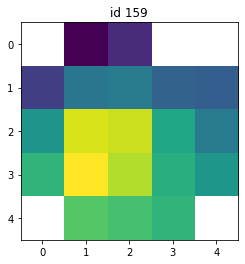

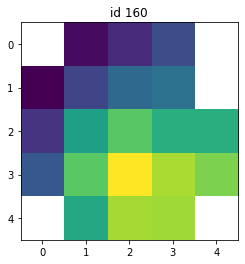

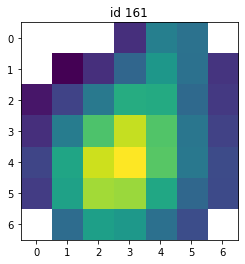

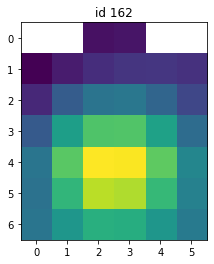

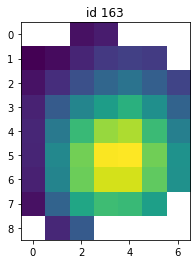

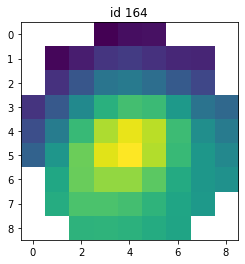

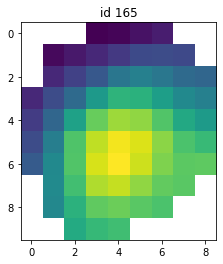

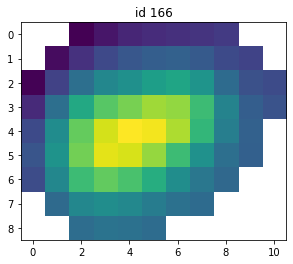

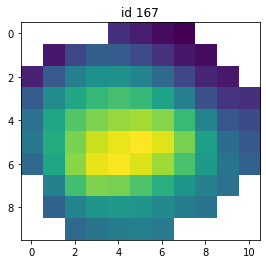

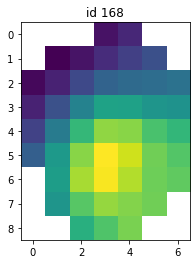

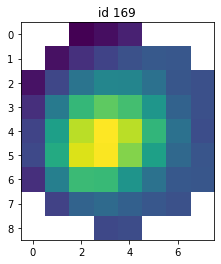

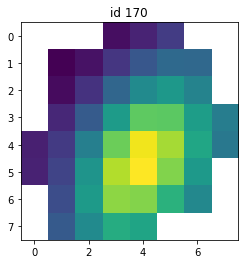

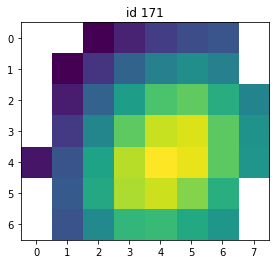

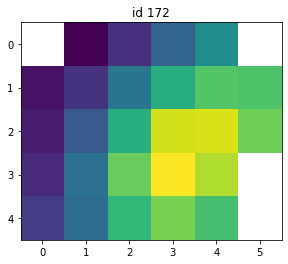

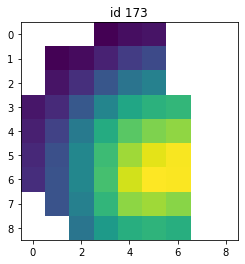

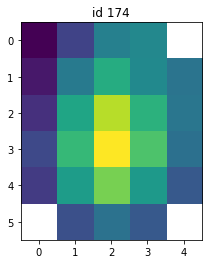

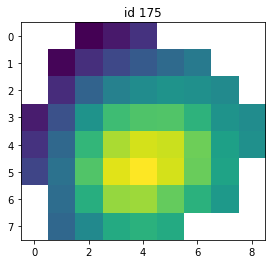

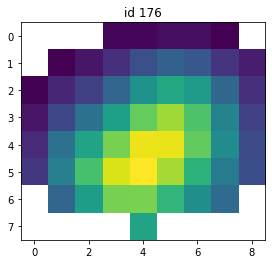

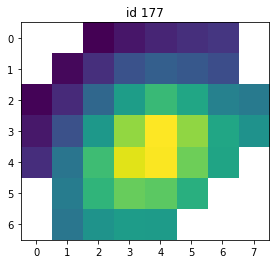

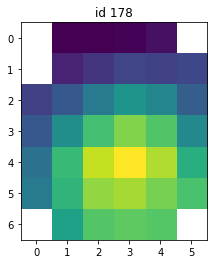

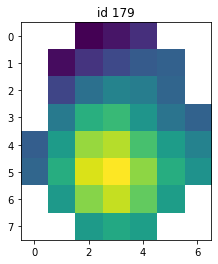

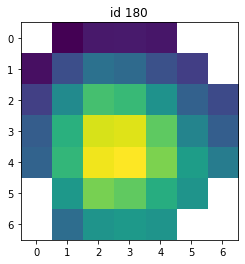

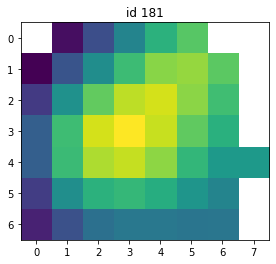

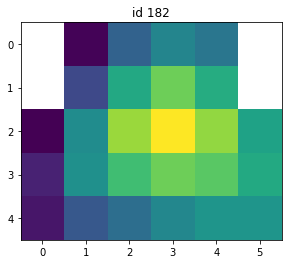

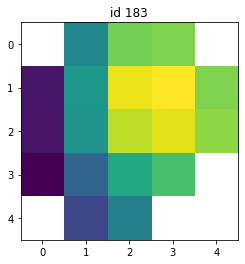

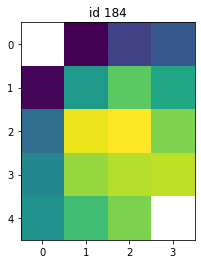

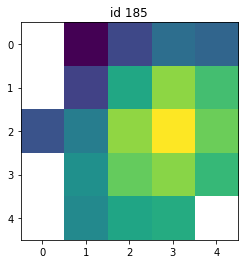

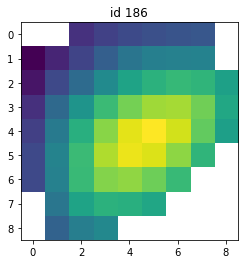

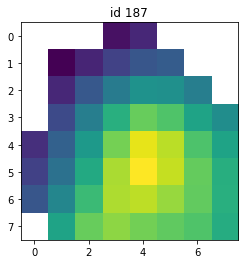

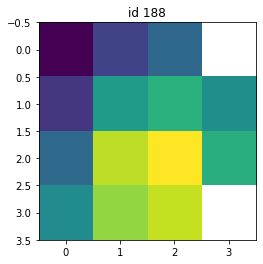

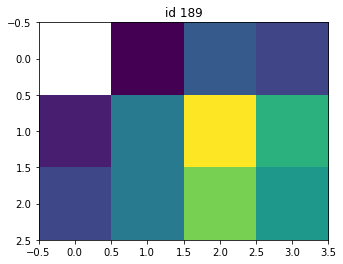

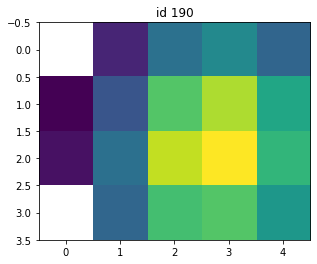

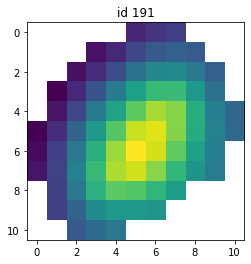

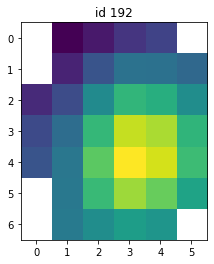

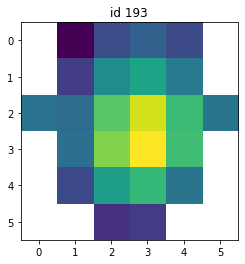

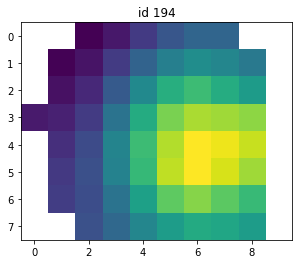

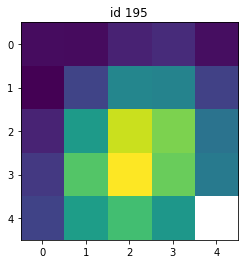

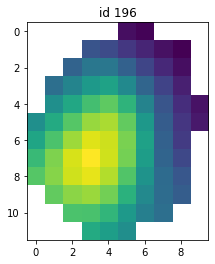

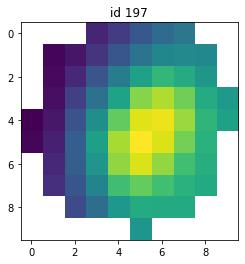

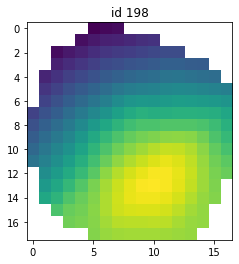

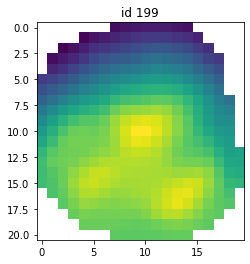

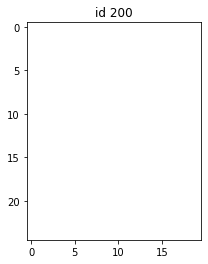

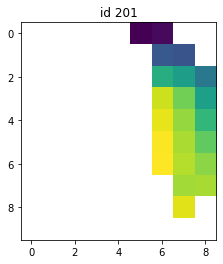

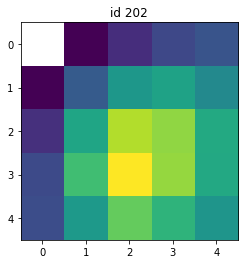

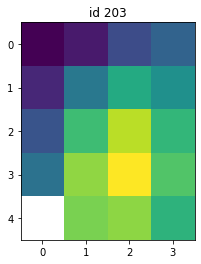

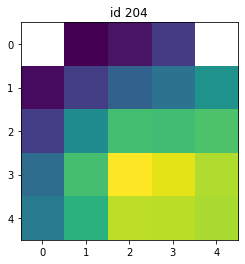

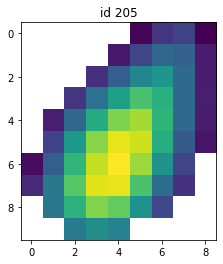

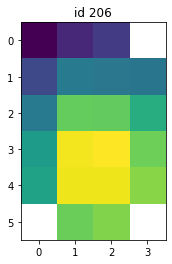

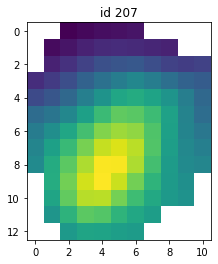

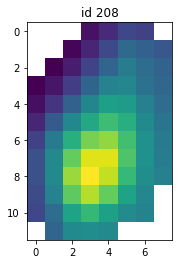

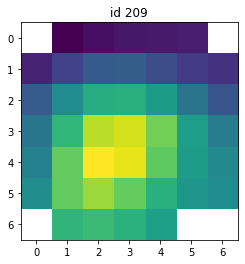

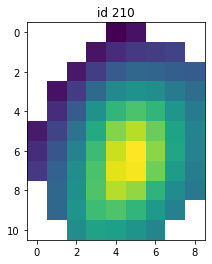

In [22]:
for i, geometry in enumerate(data_.geometry):
    enlarged = geometry.buffer(2)
    from shapely.geometry import Polygon
    pp = Polygon.from_bounds(*geometry.bounds)
    
    out_img, out_transform = mask.mask(dataset=dem_source, shapes=[enlarged], nodata=np.nan, crop=True, all_touched=True, filled=False, pad=False)
    
    figure()
    imshow(out_img[0])
    title(f"id {i}")
    
    if np.any(np.isnan(out_img)):
        print(f"{i} has nans")
        continue